<a href="https://colab.research.google.com/github/fireHedgehog/music-intrument-OvA-model/blob/main/multi-spectrogram-experiment/heatmap_feature_map_spectrograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Validation

1. Load the prepared data for validation.
2. Extract the last 50 samples for each instrument family from each spectrogram type.
3. Combine these samples into a single validation dataset.
4. Map the true labels back to the NSynth dataset labels, excluding "synth_lead."
5. Perform validation and save the results.
6. Adapted Validation Code

In [1]:
import tensorflow as tf
import numpy as np
import os
from google.colab import drive
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import cv2  # Import OpenCV for resizing


Mount google drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Need to generate the polyphony samples



define the global vars

In [3]:
# Directory paths
base_dir = '/content/drive/My Drive/200-each-instrument/'
combined_save_dir = os.path.join(base_dir, 'all_combined_with_padding')
output_dir = '/content/drive/My Drive/output-multi-gram/'
models_dir = os.path.join(output_dir, 'models')
metrics_dir = os.path.join(output_dir, 'metrics')
test_results_dir = os.path.join(output_dir, 'test_results')

os.makedirs(test_results_dir, exist_ok=True)

load data


In [4]:
# Instrument families and their original NSynth labels
instrument_families = {
    'bass': 0,
    'brass': 1,
    'flute': 2,
    'guitar': 3,
    'keyboard': 4,
    'mallet': 5,
    'organ': 6,
    'reed': 7,
    'string': 8,
    #'synth_lead' : 9, missing from tensorflow dataset
    'vocal': 10
}

# Spectrogram types
spectrogram_types = ['stft', 'log_mel', 'mfcc', 'chroma', 'spectral_contrast', 'tonnetz', 'all_combined_with_padding']

# Load data function
def load_data(family, spectrogram_type=None):
    if spectrogram_type:
        if spectrogram_type != "all_combined_with_padding":
            file_path = os.path.join(base_dir, spectrogram_type, family, f'{family}_{spectrogram_type}.npy')
        else:
            file_path = os.path.join(combined_save_dir, f'{family}_combined.npy')
    else:
        file_path = os.path.join(base_dir, f'{family}.npy')
    return np.load(file_path)


load models

In [5]:
# Instrument families and their original NSynth labels
instrument_families = {
    'bass': 0,
    'brass': 1,
    'flute': 2,
    'guitar': 3,
    'keyboard': 4,
    'mallet': 5,
    'organ': 6,
    'reed': 7,
    'string': 8,
    #'synth_lead' : 9, missing from tensorflow dataset
    'vocal': 9  # Adjusted index to 9 since 'synth_lead' is missing
}

# Spectrogram types
spectrogram_types = ['stft', 'log_mel', 'mfcc', 'chroma', 'spectral_contrast', 'tonnetz', 'all_combined_with_padding']

# Load data function
def load_data(family, spectrogram_type=None):
    if spectrogram_type:
        if spectrogram_type != "all_combined_with_padding":
            file_path = os.path.join(base_dir, spectrogram_type, family, f'{family}_{spectrogram_type}.npy')
        else:
            file_path = os.path.join(combined_save_dir, f'{family}_combined.npy')
    else:
        file_path = os.path.join(base_dir, f'{family}.npy')
    return np.load(file_path)


# Load models function
def load_models(spectrogram_type):
    model_cache = {}
    for family in instrument_families:
        model_path = os.path.join(models_dir, spectrogram_type, f'{spectrogram_type}_{family}.h5')
        model_cache[family] = load_model(model_path)
    return model_cache

# Function to resize spectrograms
def resize_spectrogram(spectrogram, target_shape):
    return cv2.resize(spectrogram, target_shape, interpolation=cv2.INTER_CUBIC)


In [33]:
# Example parameters
plot_spectrogram = 'stft'
model_name = 'bass'
intermediate_heatmap_layer = 'conv2d_3'
sample_index = 0

In [35]:
# Load the model (assuming the models are saved with a naming convention like 'model_{plot_spectrogram}_{model_name}.h5')
model_path = os.path.join(models_dir, plot_spectrogram, f'{plot_spectrogram}_{model_name}.h5')
loaded_model = tf.keras.models.load_model(model_path)

In [21]:
for layer in loaded_model.layers:
    print(f"{layer.name}: trainable = {layer.trainable}")

conv2d: trainable = True
conv2d_1: trainable = True
max_pooling2d: trainable = True
dropout: trainable = True
conv2d_2: trainable = True
conv2d_3: trainable = True
max_pooling2d_1: trainable = True
dropout_1: trainable = True
conv2d_4: trainable = True
conv2d_5: trainable = True
max_pooling2d_2: trainable = True
dropout_2: trainable = True
flatten: trainable = True
dense: trainable = True
dropout_3: trainable = True
dense_1: trainable = True


In [38]:
# Load the dataset (assuming x_data is pre-loaded or can be loaded here)
x_data = load_data(family=model_name, spectrogram_type=plot_spectrogram)

In [36]:
def create_intermediate_model(loaded_model, layer_name):
    intermediate_model = tf.keras.Model(
        inputs=loaded_model.input,
        outputs=loaded_model.get_layer(layer_name).output
    )
    return intermediate_model

# Create the intermediate model for the specified layer
intermediate_model = create_intermediate_model(loaded_model, intermediate_heatmap_layer)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_maps(intermediate_model, x_data, sample_index=0, aspect_ratio='auto'):
    output = intermediate_model.predict(np.expand_dims(x_data[sample_index], axis=0))

    num_filters = output.shape[-1]
    num_filters_to_show = min(6, num_filters)  # Show up to 6 filters
    height, width = output.shape[1], output.shape[2]

    # Adjust figure size to modify aspect ratio
    plt.figure(figsize=(20, round(num_filters_to_show * 3)/4))
    for i in range(num_filters_to_show):
        plt.subplot(1, num_filters_to_show, i + 1)
        plt.imshow(output[0, :, :, i], aspect=aspect_ratio, cmap='viridis')
        plt.title(f'Filter {i + 1}\n({width}x{height})')
        plt.axis('off')
    plt.show()

In [12]:
def plot_intermediate_heatmap(model, x_data, layer_name, sample_index=0):
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    with tf.GradientTape() as tape:
        inputs = tf.cast(np.expand_dims(x_data[sample_index], axis=0), tf.float32)
        tape.watch(inputs)
        intermediate_output = intermediate_layer_model(inputs)
        predicted_class = tf.argmax(model(inputs)[0])

    grads = tape.gradient(intermediate_output, inputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, intermediate_output), axis=-1).numpy()

    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap[0], aspect='auto', cmap='viridis')
    plt.title(f'Heatmap for {layer_name}', fontsize=16)
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

def plot_grad_cam(heatmap, img):
    plt.figure(figsize=(10, 8))
    plt.imshow(img, aspect='auto', cmap='viridis')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title('Grad-CAM Heatmap', fontsize=16)
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [14]:
def plot_saliency_map(model, x_data, sample_index=0):
    # Ensure the inputs are correctly shaped
    inputs = tf.cast(np.expand_dims(x_data[sample_index], axis=0), tf.float32)
    print(f"Inputs shape: {inputs.shape}")

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
        predicted_class = tf.argmax(predictions[0])
        print(f"Predictions: {predictions}")
        print(f"Predicted Class: {predicted_class}")
        target_class_output = predictions[:, predicted_class]
        print(f"Target Class Output: {target_class_output}")

    grads = tape.gradient(target_class_output, inputs)

    if grads is None:
        print("Gradients are None")
        return

    # Ensure gradients have the correct shape
    print(f"Gradients shape: {grads.shape}")

    # Compute saliency map with the same shape as the input
    saliency = tf.reduce_max(tf.abs(grads), axis=0).numpy()
    print(f"Saliency shape: {saliency.shape}")

    plt.figure(figsize=(10, 8))
    plt.imshow(saliency, aspect='auto', cmap='viridis')
    plt.title('Saliency Map', fontsize=16)
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [15]:
def plot_gradient_heatmap(model, x_data, sample_index=0):
    # Ensure the inputs are correctly shaped
    inputs = tf.cast(np.expand_dims(x_data[sample_index], axis=0), tf.float32)
    print(f"Inputs shape: {inputs.shape}")

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
        predicted_class = tf.argmax(predictions[0])
        print(f"Predictions: {predictions}")
        print(f"Predicted Class: {predicted_class}")
        target_class_output = predictions[:, predicted_class]
        print(f"Target Class Output: {target_class_output}")

    grads = tape.gradient(target_class_output, inputs)

    if grads is None:
        print("Gradients are None")
        return

    # Ensure gradients have the correct shape
    print(f"Gradients shape: {grads.shape}")

    # Compute heatmap with the same shape as the input
    heatmap = tf.reduce_max(tf.abs(grads), axis=0).numpy()
    print(f"Heatmap shape: {heatmap.shape}")

    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap, aspect='auto', cmap='viridis')
    plt.title('Gradient Heatmap', fontsize=16)
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [16]:
def integrated_gradients(inputs, model, target_class_index, baseline=None, num_steps=50):
    if baseline is None:
        baseline = tf.zeros_like(inputs)

    inputs = tf.cast(inputs, tf.float32)
    baseline = tf.cast(baseline, tf.float32)
    scaled_inputs = [baseline + (float(i) / num_steps) * (inputs - baseline) for i in range(num_steps + 1)]

    grads = []
    with tf.GradientTape(persistent=True) as tape:
        for inp in scaled_inputs:
            tape.watch(inp)
            predictions = model(inp)
            target_predictions = predictions[:, target_class_index]
            grads.append(tape.gradient(target_predictions, inp))

    grads = tf.convert_to_tensor(grads)

    if any(g is None for g in grads):
        print("Some gradients are None")
        return None

    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grad = (inputs - baseline) * avg_grads
    return integrated_grad

def plot_integrated_gradients(model, x_data, sample_index=0, baseline=None, num_steps=50):
    inputs = tf.cast(np.expand_dims(x_data[sample_index], axis=0), tf.float32)
    predictions = model(inputs)
    predicted_class = tf.argmax(predictions[0])

    integrated_grad = integrated_gradients(inputs, model, predicted_class, baseline, num_steps)

    if integrated_grad is None:
        print("Integrated gradients computation failed")
        return

    integrated_grad = integrated_grad.numpy()[0]

    plt.figure(figsize=(10, 8))
    plt.imshow(np.abs(integrated_grad), aspect='auto', cmap='viridis')
    plt.title('Integrated Gradients', fontsize=16)
    plt.colorbar()
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 21ms/step


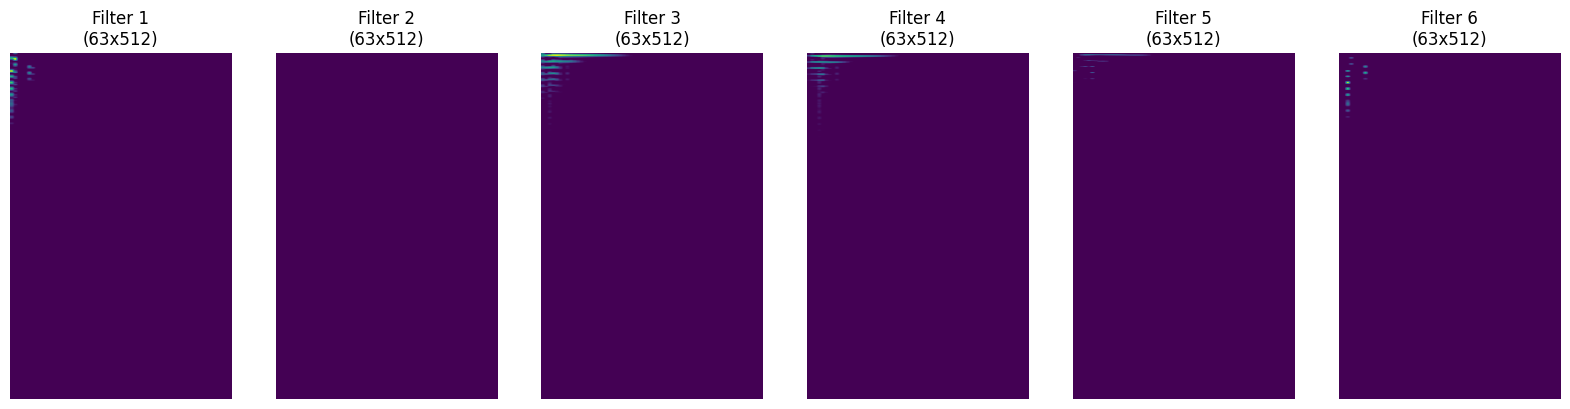

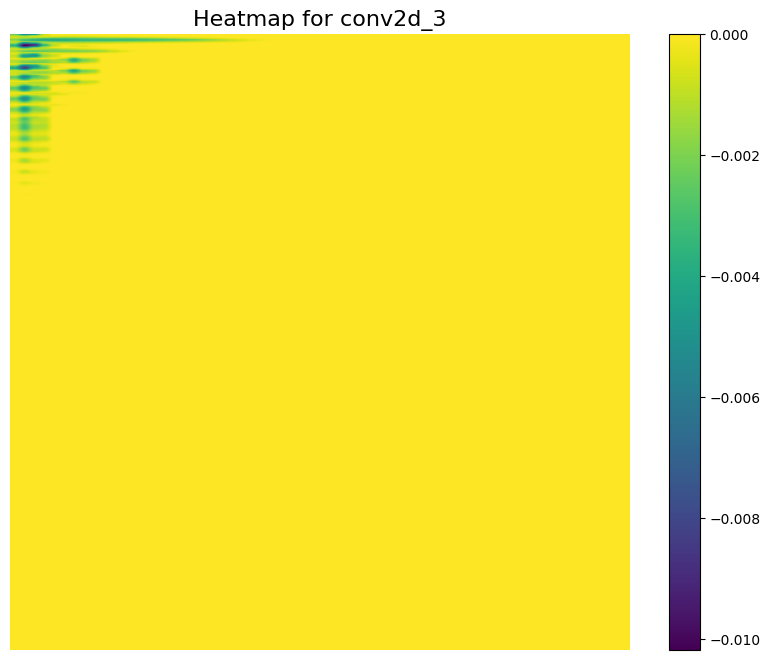

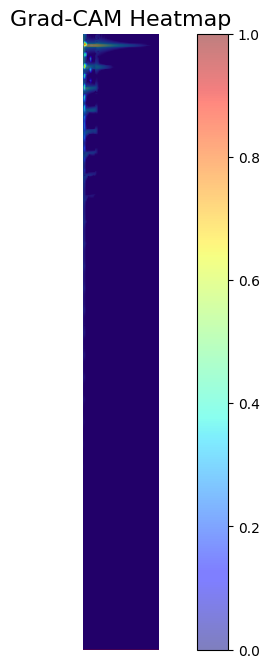

Inputs shape: (1, 1025, 126)
Predictions: [[0.20120098]]
Predicted Class: 0
Target Class Output: [0.20120098]
Gradients shape: (1, 1025, 126)
Saliency shape: (1025, 126)


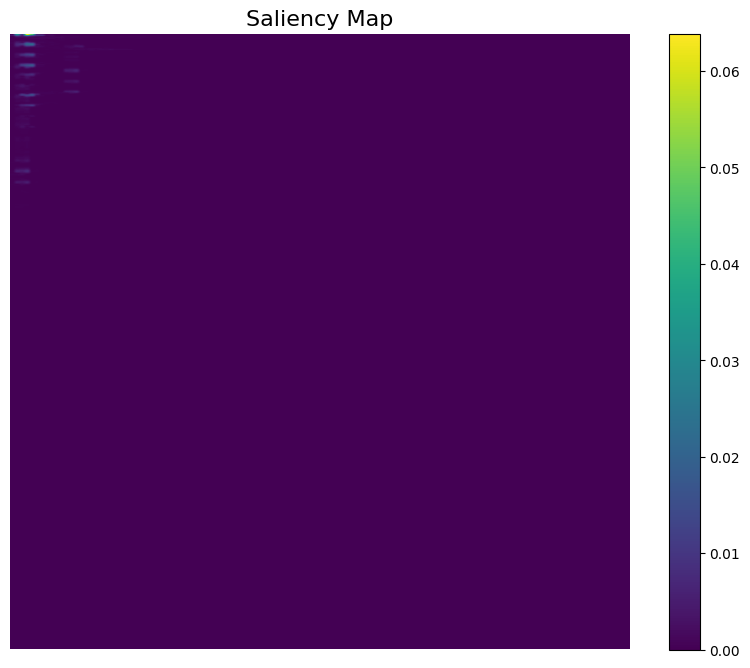

Inputs shape: (1, 1025, 126)
Predictions: [[0.20120098]]
Predicted Class: 0
Target Class Output: [0.20120098]
Gradients shape: (1, 1025, 126)
Heatmap shape: (1025, 126)


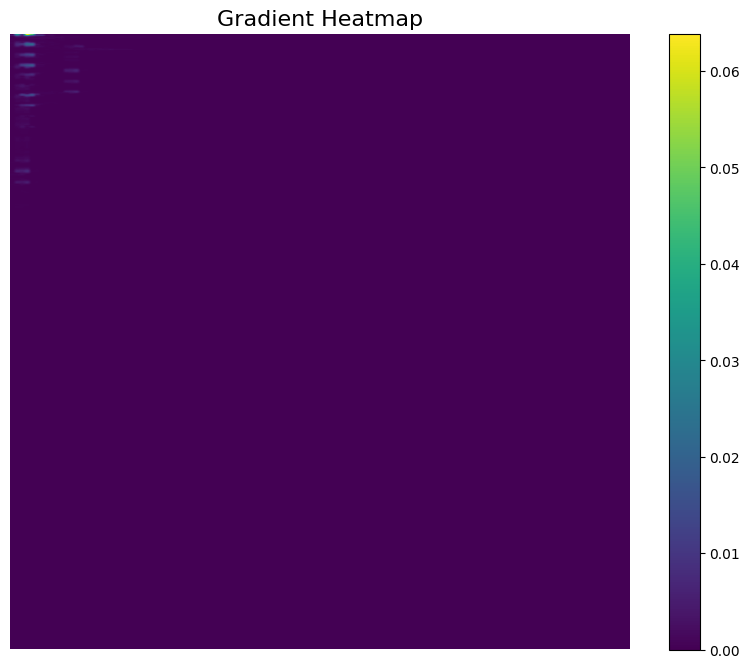

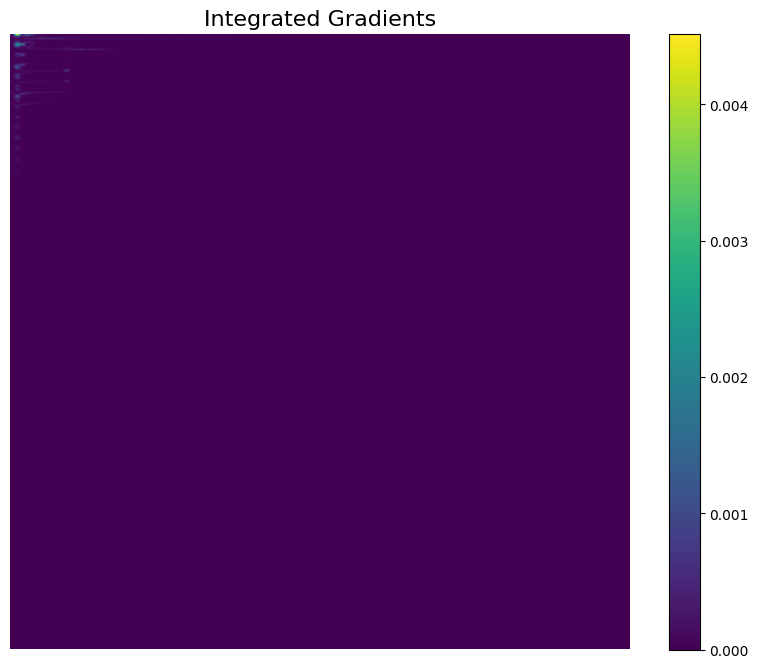

In [39]:
# plot_feature_maps
plot_feature_maps(intermediate_model, x_data, sample_index=sample_index, aspect_ratio='auto')
# plot_intermediate_heatmap
plot_intermediate_heatmap(loaded_model, x_data, intermediate_heatmap_layer, sample_index=sample_index)
# grad_cam
img_array = np.expand_dims(x_data[sample_index], axis=0)
heatmap = grad_cam(loaded_model, img_array, intermediate_heatmap_layer)
plot_grad_cam(heatmap, x_data[sample_index])
# plot_saliency_map
plot_saliency_map(loaded_model, x_data, sample_index=sample_index)
# plot_gradient_heatmap
plot_gradient_heatmap(loaded_model, x_data, sample_index=sample_index)
# plot_integrated_gradients
plot_integrated_gradients(loaded_model, x_data, sample_index=sample_index)

In [ ]:
def plot_and_save_integrated_gradients(spectrogram_type, model_cache):
    x_val = []
    y_val = []

    for family, label in instrument_families.items():
        data_check = load_data(family, spectrogram_type)[:1] # check the first training sample size
        data = load_data(family, spectrogram_type)[-50:]  # Get the last 50 samples
        if data[0].shape != data_check[0].shape:
            # 6(spetrogram)+1(all_combined) * 10(instrument) = 70(senario) so need to debug if there is a mistake while we generate the data
            print(f"Resizing required for {spectrogram_type}, {family}, index: 0")
            print(f"Training shape: {data_check[0].shape}, Testing shape: {data[0].shape}")

            target_shape = data_check[0].shape
            resized_data = np.array([resize_spectrogram(s, target_shape) for s in data])
        else:
            resized_data = data

        resized_data

In [ ]:
# Main validation loop for all spectrogram types
for spectrogram_type in spectrogram_types:
    model_cache = load_models(spectrogram_type)
    plot_and_save_integrated_gradients(spectrogram_type, model_cache)

print("plot completed and results saved.")

In [ ]:
import numpy as np
import tensorflow as tf
import os
from scipy.stats import entropy
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance


def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

def compute_integrated_gradients(inputs, model, target_class_index, baseline=None, num_steps=50):
    if baseline is None:
        baseline = tf.zeros_like(inputs)

    inputs = tf.cast(inputs, tf.float32)
    baseline = tf.cast(baseline, tf.float32)
    scaled_inputs = [baseline + (float(i) / num_steps) * (inputs - baseline) for i in range(num_steps + 1)]

    grads = []
    with tf.GradientTape(persistent=True) as tape:
        for inp in scaled_inputs:
            tape.watch(inp)
            predictions = model(inp)
            target_predictions = predictions[:, target_class_index]
            grads.append(tape.gradient(target_predictions, inp))

    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grad = (inputs - baseline) * avg_grads
    return integrated_grad.numpy()[0]

def generate_and_store_integrated_gradients(model, x_data, save_dir, num_samples=50, baseline=None, num_steps=50):
    create_directory(save_dir)
    heatmaps = []

    for i in range(num_samples):
        inputs = tf.cast(np.expand_dims(x_data[i], axis=0), tf.float32)
        predicted_class = tf.argmax(model(inputs)[0])

        integrated_grad = compute_integrated_gradients(inputs, model, predicted_class, baseline, num_steps)
        heatmaps.append(integrated_grad)

        # Save integrated gradient heatmap
        np.save(os.path.join(save_dir, f'integrated_grad_{i}.npy'), integrated_grad)

    return np.array(heatmaps)

def load_integrated_gradients(load_dir, num_samples):
    heatmaps = []

    for i in range(num_samples):
        heatmaps.append(np.load(os.path.join(load_dir, f'integrated_grad_{i}.npy')))

    return np.array(heatmaps)

def compute_metrics(heatmaps):
    num_samples = len(heatmaps)
    differences = []
    kl_divergences = []
    js_divergences = []
    em_distances = []

    for i in range(num_samples):
        for j in range(i + 1, num_samples):
            difference = np.abs(heatmaps[i] - heatmaps[j])
            differences.append(np.mean(difference))

            p = heatmaps[i].flatten() / np.sum(heatmaps[i])
            q = heatmaps[j].flatten() / np.sum(heatmaps[j])

            # Add a small constant to avoid zero values
            epsilon = 1e-8
            p = np.clip(p, epsilon, 1)
            q = np.clip(q, epsilon, 1)

            # Normalize again after clipping
            p /= np.sum(p)
            q /= np.sum(q)

            kl_div = entropy(p, q)
            js_div = jensenshannon(p, q)**2
            emd = wasserstein_distance(p, q)

            kl_divergences.append(kl_div)
            js_divergences.append(js_div)
            em_distances.append(emd)

            # Debug prints
            print(f'Comparing sample {i} and {j}')
            print(f'Difference mean: {np.mean(difference)}')
            print(f'KL Divergence: {kl_div}')
            print(f'Jensen-Shannon Divergence: {js_div}')
            print(f'Earth Mover\'s Distance: {emd}')

    differences = np.array(differences)
    kl_divergences = np.array(kl_divergences)
    js_divergences = np.array(js_divergences)
    em_distances = np.array(em_distances)

    # Remove any infinite values
    kl_divergences = kl_divergences[np.isfinite(kl_divergences)]
    js_divergences = js_divergences[np.isfinite(js_divergences)]
    em_distances = em_distances[np.isfinite(em_distances)]

    return differences, kl_divergences, js_divergences, em_distances

def visualize_metrics(differences, kl_divergences, js_divergences, em_distances, instrument, spectrogram_type, save_path):
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.hist(differences, bins=20, color='blue', alpha=0.7)
    plt.title(f'{instrument} - {spectrogram_type}\nHistogram of Heatmap Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 2)
    plt.hist(kl_divergences, bins=20, color='green', alpha=0.7)
    plt.title(f'{instrument} - {spectrogram_type}\nHistogram of KL Divergences')
    plt.xlabel('KL Divergence')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 3)
    plt.hist(js_divergences, bins=20, color='red', alpha=0.7)
    plt.title(f'{instrument} - {spectrogram_type}\nHistogram of Jensen-Shannon Divergences')
    plt.xlabel('JS Divergence')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 4)
    plt.hist(em_distances, bins=20, color='purple', alpha=0.7)
    plt.title(f'{instrument} - {spectrogram_type}\nHistogram of Earth Mover\'s Distances')
    plt.xlabel('EM Distance')
    plt.ylabel('Frequency')

    plt.tight_layout()
    create_directory(save_path)
    plt.savefig(os.path.join(save_path, f'{instrument}_{spectrogram_type}_metrics.png'))
    plt.close()

In [ ]:
# Loop over all instruments and spectrogram types
base_dir = '/content/drive/My Drive/200-each-instrument/'
output_dir = '/content/drive/My Drive/output-multi-gram/'

models_dir = os.path.join(output_dir, 'models')
save_base_dir = os.path.join(output_dir, 'plot-heatmap')

sample_index = 0  # Example index, adjust as needed
num_samples = 50  # Number of samples per instrument and spectrogram type

In [ ]:
import gc
from tensorflow.keras.backend import clear_session

# Collect garbage
gc.collect()

# Clear TensorFlow/Keras session
clear_session()

In [ ]:
spectrogram_types=['stft']
model_cache = load_models('stft') # debug one at a time, because it requires over 40G gpu ram

In [ ]:
for spectrogram_type in spectrogram_types:
    for instrument, model in model_cache.items():
        save_path = os.path.join(save_base_dir, spectrogram_type, instrument)
        x_data = load_data(instrument, spectrogram_type)

        # Generate and store integrated gradients
        heatmaps = generate_and_store_integrated_gradients(model, x_data, save_path, num_samples)

        # Compute metrics
        differences, kl_divergences, js_divergences, em_distances = compute_metrics(heatmaps)

        # Visualize metrics
        visualize_metrics(differences, kl_divergences, js_divergences, em_distances, instrument, spectrogram_type, save_path)

following code is when we do the task next time.
only need to read the stored data, no need to save it again

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Function to load saved heatmaps
def load_saved_heatmaps(save_base_dir, spectrogram_type, instrument, num_samples):
    heatmaps = []
    for i in range(num_samples):
        heatmap_path = os.path.join(save_base_dir, spectrogram_type, instrument, f'integrated_grad_{i}.npy')
        heatmap = np.load(heatmap_path)
        heatmaps.append(heatmap)
    return np.array(heatmaps)


In [ ]:
for spectrogram_type in spectrogram_types:
    for instrument in instrument_families:
        save_path = os.path.join(save_base_dir, spectrogram_type, instrument)

        # Load saved heatmaps
        heatmaps = load_saved_heatmaps(save_base_dir, spectrogram_type, instrument, num_samples)

        # Compute metrics
        differences, kl_divergences, js_divergences, em_distances = compute_metrics(heatmaps)

        # Visualize metrics
        visualize_metrics(differences, kl_divergences, js_divergences, em_distances, instrument, spectrogram_type, save_path)

Streaming output truncated to the last 5000 lines.
Comparing sample 4 and 40
Difference mean: 0.000349318579537794
KL Divergence: 7.336174011230469
Jensen-Shannon Divergence: 0.5362347364425658
Earth Mover's Distance: 1.0963358812708092e-06
Comparing sample 4 and 41
Difference mean: 0.00022441046894527972
KL Divergence: 7.155483245849609
Jensen-Shannon Divergence: 0.5747333765029907
Earth Mover's Distance: 4.452645188538557e-06
Comparing sample 4 and 42
Difference mean: 0.0005675646825693548
KL Divergence: 10.286300659179688
Jensen-Shannon Divergence: 0.5932262539863585
Earth Mover's Distance: 2.7338218167246065e-06
Comparing sample 4 and 43
Difference mean: 0.00036954530514776707
KL Divergence: 7.847931861877441
Jensen-Shannon Divergence: 0.5570278167724609
Earth Mover's Distance: 2.084646729456456e-06
Comparing sample 4 and 44
Difference mean: 0.00022836994321551174
KL Divergence: 7.276639938354492
Jensen-Shannon Divergence: 0.5595240592956543
Earth Mover's Distance: 2.96075711064876